## Motivation

Image data-- particularly *labeled* image data-- is tough to come by. All told, if you've got 1000 images split, say, 500/250/250 and naively dump it into a model, you're on a fast track to overfitting. A CV application that correctly spots a particular cat on the left side of an image should have no problem finding it on the right side if the image were flipped, yeah?

*Data Augmentation*, such as flipping, rotation, shearing, and zooming allows us to introduce noise and variability to our images, thus generating "more" training data.

The `keras` library has some awesome tools to facilitate doing just this.

## Structuring Your Data

So following along with the example from [Chollet's Deep Learning with Python book](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438), we're going to take a look at the [Kaggle dogs-vs-cats dataset.](https://www.kaggle.com/c/dogs-vs-cats)

After a big ol' download and unzipping, we've got a few thousand images that looks like

```
cat.1.jpg
dog.1.jpg
cat.2.jpg
dog.2.jpg
...
```

Before we take a look at the helper objects that `keras` has to offer, we have to do a bit of data organization.

Concretely, we want to create a hierarchical structure that looks like

```
train
   |-- cats
         |-- cat.1.jpg
         |-- cat.2.jpg
         |-- ...
   |-- dogs
test
   |-- cats
   |-- dogs
validation
   |-- cats
   |-- dogs
```

Chollet achieves this by shelling out the folder structure, some `os` and `shutil` magic, and varitions on the following.

``` python
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
```

Next, we'll build a simple convnet model object so we have something we can pass into.

In [17]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 175232)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               89719296  
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 89,720,705
Trainable params: 89,720,705
Non-trainable params: 0
_________________________________________________________________


## The `ImageDataGenerator` Object

### Using it to get raw files

Now that we've got our organized data and a model, we need a way to hook the two together. For this, we'll employ the `ImageDataGenerator`, which spins up a Python generator that allows lazy-serving of images as we need them.

In [7]:
from keras.preprocessing.image import ImageDataGenerator

Rescaling by `1./255` is a best practice. The `1.` enforces a `float` type, and scaling by the max `RGB` value helps our algorithm converge better.

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

The syntax here is pretty straight-forward. We tell our generator that we want it to lazily flow from a certain image directory, specifying the size of the images, how many images to take at once, and how resolve the subdirectories when building the target data (binary, multiclass, etc)

Running these, we get a nice sanity check printout that we can use to validate that our folder structure is correct.

In [9]:
train_generator = train_datagen.flow_from_directory(
        'images/train',
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'images/validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Fitting a model with it

Using the generator object with a keras model is as easy as calling the `fit_generator()` method, with the usual arguments supplied

In [11]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/5
100/100 [==============================] - 134s 1s/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9705 - val_acc: 0.5000
Epoch 2/5
100/100 [==============================] - 137s 1s/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9705 - val_acc: 0.5000
Epoch 3/5
100/100 [==============================] - 139s 1s/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9705 - val_acc: 0.5000
Epoch 4/5
100/100 [==============================] - 153s 2s/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/5
100/100 [==============================] - 146s 1s/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000


## Augmenting Our Data

Finally, if we want to use these same objects to start introducing noise into our images, it's just a matter of passing a few extra arguments to their constructors.

There are a ton of different options ([docs here](https://keras.io/preprocessing/image/)) that you can provide, but basically the way this works is:
- We get the `rescale` value for free on every single image
- All of the rest will *randomly* be applied to the next image that gets served up *or not*

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

Our test data should **not** be modified

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

This step looks the same

In [14]:
train_generator = train_datagen.flow_from_directory(
        'images/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    'images/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


And so does this one

In [15]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/5
100/100 [==============================] - 154s 2s/step - loss: 7.8716 - acc: 0.5062 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/5
100/100 [==============================] - 151s 2s/step - loss: 8.0905 - acc: 0.4894 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/5
100/100 [==============================] - 149s 1s/step - loss: 7.7912 - acc: 0.5069 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/5
100/100 [==============================] - 149s 1s/step - loss: 7.9364 - acc: 0.5022 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/5
100/100 [==============================] - 156s 2s/step - loss: 5.5399 - acc: 0.5116 - val_loss: 0.6810 - val_acc: 0.5640


## What does this look like?

The generator will randomly pluck images from the directories and *maybe* apply transformations to them. Running a few times, we'll likely see some that look obviously altered.

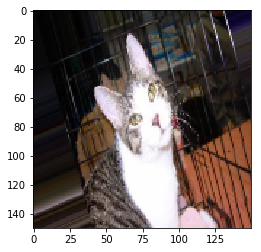

In [35]:
for X, y in train_generator:
    plt.imshow(X[0])
    break

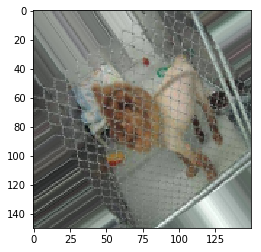

In [36]:
for X, y in train_generator:
    plt.imshow(X[0])
    break

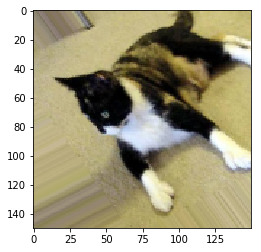

In [37]:
for X, y in train_generator:
    plt.imshow(X[0])
    break

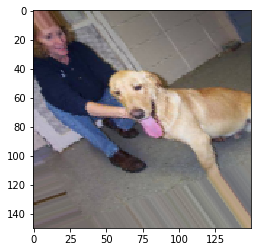

In [38]:
for X, y in train_generator:
    plt.imshow(X[0])
    break

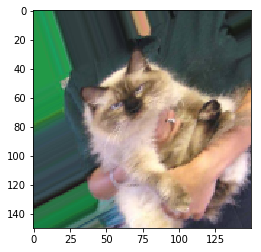

In [39]:
for X, y in train_generator:
    plt.imshow(X[0])
    break

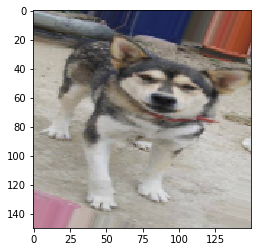

In [40]:
for X, y in train_generator:
    plt.imshow(X[0])
    break